# Ensemble Spread and Statistical Significance
### Authors

Samantha Stevenson sstevenson@ucsb.edu

### Table of Contents

[Goals](#purpose)

[Import Packages](#path)

[Load and Query the CMIP6 AWS Catalog](#load)

[Pull Data of Interest: Historical Plus SSP](#data_io)

[Apply CA State Region Mask](#mask)

[Build PDFs of Regionally Averaged Data](#pdfs)

[Perform Significance Tests](#sigtests)

<a id='purpose'></a> 
## **Goals**

In this tutorial, we will learn some techniques for assessing _statistical significance_ of changes in climate data, given the presence of _internal climate variability_ as measured by ensemble spread.

This will allow you to practice skills learned in previous tutorials:
- [Mapping Climate Data](https://github.com/climate-datalab/Map-Plots/blob/main/1.%20Mapping%20Climate%20Data.ipynb) (putting spatial data onto a map using Cartopy)
- [Plotting Regional Time Series Using Shapefiles](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/2.%20Plotting%20Regional%20Time%20Series%20Using%20Shapefiles.ipynb)  (masking out irregular regions from the climate model grid using shape files)

while also learning some new skills that will be presented below:
- **Database querying strategies** to take a more detailed look at what's inside the CMIP catalog;
- **Creating probability distribution functions** based on either time-varying information from a _single_ ensemble member, or time-averaged information from _multiple_ ensemble members; and
- **Applying T-tests and rank-sum tests** to compute the level of statistical significance of differences!

### **This is the Code-Along version of tutorial 3!!** 

This notebook contains only a selected subset of the code for tutorial 3, so that it can be completed in a "code along" format in a classroom context. If you would like the fully completed version, please see "3. Ensemble Spread and Statistics Significance.ipynb" in this repo.

<a id='path'></a> 
## **Import Packages**

As always, we begin by importing the necessary packages for our analysis. 

1) Packages from previous tutorial

This tutorial assumes you have all the packages from tutorial 2 ([Plotting Regional Time Series Using Shapefiles](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/2.%20Plotting%20Regional%20Time%20Series%20Using%20Shapefiles.ipynb)) installed; if you need more information on these packages, please refer to that tutorial.

2) New package: `scipy`

In addition to these packages, we'll also be working with a new one called Scipy! This is a really powerful package that's designed to do all sorts of complex scientific computations using the features of Numpy - some examples include solving differential equations and interpolating between missing data points. Here we're mainly going to be using Scipy's statistics functionality, which is stored in the `scipy.stats` sub-package. We can just load that one into our environment as `stats`.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import intake
import s3fs
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import scipy.stats as stats

ERROR 1: PROJ: proj_create_from_database: Open of /opt/anaconda3/envs/eds296-stevenson/share/proj failed


<a id='load'></a> 
## **Load and Query the CMIP6 AWS Catalog**

As we did in previous tutorials, we'll load the CMIP6 database hosted by Amazon Web Services:

In [2]:
# Open the CMIP6 data catalog, store as a variable
catalog = intake.open_esm_datastore('https://cmip6-pds.s3.amazonaws.com/pangeo-cmip6.json')

To make things a bit more interesting, let's practice looking through the catalog, to find a couple of good model ensembles to work with. 

Let's say we're trying to find some ensembles of **historical** output! Here is a recommended workflow to look through the catalog and pick some data.

1) Specify the `experiment_id`: since the "historical" experiments are ALL part of the "CMIP" activity, you DON'T need to also set the `activity_id` field here.

2) Specify the `table_id` and `variable_id` fields: sometimes different sets of variables are available with different models, so picking out one variable and time frequency can be helpful in identifying the exact ensemble members you'll be using.

In [3]:
# Specify search terms to query catalog 
# experiment_id: what experimental configuration do you want? Here we want historical 

# table_id: which part of the Earth system and time resolution do you want? Here we want monthly atmosphere data

# variable_id: which climate variable do you want? 

# Extract the part of the catalog that goes with these search terms


2) Take a look at the data frame to see how many different models there are that ran historical simulations: you can do this by applying the `.unique()` function to the `source_id` field in the catalog dataframe.

In [26]:
# Find all unique models that ran historical simulations


3) Choose a couple of entries from the above at random, and see how many ensemble members are available in each. For the activities below we're going to want to have a fair amount of data available: let's set 5 members as an arbitrary minimum threshold. Let's also not use HUGE ensembles here, to make the code run faster! So... **can we find models that have between 5 and 10 historical ensemble members??**

To answer this question, pick some model names, enter them as the `source_id` term in the call to `catalog.search`, then from the data frame that comes back as a result display the unique values of `member_id`. You can even get fancy, and **loop** over all the possible model `source_ids` then display the unique set of ensemble members that goes with each one!

This is demonstrated in the code block below:

In [ ]:
# source_id: which model do you want? 

for src in source_id:
    # Print out the name of the model we're working with, to keep track of things
    print(src)
    
    # Extract the part of the catalog that goes with this model

    # Print the unique member ids
    
    # AND/OR print the number of unique members


After some playing with the results, I've decided to go with the following:
- **ACCESS-CM2: 5 ensemble members**

You can change this around if you want though!

For a bit more information about ACCESS-CM2: this is an Australian climate model, the Australian Community Climate and Earth System Simulator. They have lots of background information about ACCESS on the [ACCESS homepage](https://research.csiro.au/access/about/)!

**helpful tip:** if you're curious about any given model you might come across, just Google the name! There's probably a handy webpage out there waiting to explain it to you.

<a id='data_io'></a> 
## **Pull Data of Interest: Historical Plus SSP**

Now that we've picked a model, let's go ahead and collect all the data for it. 

As an additional task, I'm ALSO going to demonstrate how to extract information for BOTH the historical and future projection data associated with a given model ensemble, and concatenate these together in a way that matches ensemble members to one another. This is a tool that will come in handy throughout your climate modeling adventures, since it allows you to:
- be sure that you don't have any weird discontinuities in your time series from mismatches between ensemble members
- easily subset your data for any time period you want, without worrying about whether it's in the historical or the SSP dataset

We'll begin with more catalog queries, for our selected model ACCESS-CM2. But now we're going to do it twice: once for the historical simulations and once for the future projections! This means choosing a future scenario - just for the sake of picking something, we'll choose SSP3-7.0 (or in the CMIP6 catalog, `ssp370`).

In [6]:
# Extract data just for ACCESS-CM2
# Specify search terms to query catalog 

# Extract historical data

# Extract future SSP projection data


In [29]:
# Print the data frames


From printing out the data frames above and looking at the `member_id` field, we can see that this dataset is nice and well behaved: all the same ensemble members are available in the historical and the SSP3-7.0 ensembles, and the members are listed in the same order. **This will not always be the case!!** Sometimes modeling centers don't extend all historical simulations out to 2100 using the SSP scenarios, and sometimes they'll end up reordered in random ways relative to one another. 

What do we do about this situation? It's not too bad, really: we just have to make sure that as we're reading in data, the ensemble members _match_ between the historical and future projection simulations.

We'll go through essentially the same process outlined in tutorials 1 and 2 in this repo: looping over each unique ensemble member, reading in the data from the zarr store as an individual xarray Dataset, then building a list of xarray objects. From there, we'll use `xr.concat` to transform the list into a larger xarray Dataset with a new dimension called `member`, the coordinate for which is the name of each unique ensemble member.

**But now there's a twist**: the members we'll loop over will be ONLY those that are in BOTH the historical AND the future projection ensembles!

Not only that, but we'll also add code that will automatically LOCATE the ensemble member we want inside the two data frames we created above. 

#### **Here's how it works:**

First, we locate the members that are common across the historical and SSP ensembles. We can do this by converting the lists of unique members from each ensembles to sets using the `set()` command, then calculating the [_set intersection_](https://www.w3schools.com/python/ref_set_intersection.asp) between them (syntax for this is `set1 & set2`), then converting this back to a list using the `list()` command. To make the code shorter, I did all of the above in a single line:

In [8]:
# Make a list of the unique ensemble members
# historical

# SSP


# Convert these to sets, find the intersection between them, and convert back to a list


Now we've got a new list of members to iterate over! In this particular case, it's the exact same list we had before - but again, that likely won't be the case in every example you encounter.

We apply the same approach of looping over the number of unique ensemble members - but now, there's new line code _inside_ the loop, that does a couple of things:
- finds where the particular ensemble member we want is in each data frame (historical and SSP)
- extracts data individually from each data frame from that location
- concatenates the historical and SSP data across the time dimension

THEN puts the concatenated data for that ensemble member into the list of output data!

In [ ]:
# Define an empty list for output data
access_data = []

# Retrieve number of members the historical and SSP ensembles have in common
num = len(common_mems)

# Loop over all members-in-common
for mem in range(num):
    # Print statement to keep track of which member we're working on
    print(common_mems[mem])
    
    # Figure out where this member is in the historical ensemble
    # True/False array showing whether or not the member_id matches our member of interest
    
    # extract (first) location where the mask is True
    
    
    # Do the same thing for the SSP ensemble
    
    # Extract data from each entry as xarray
    
    # Concatenate the historical and SSP data across the time dimension
    
    # Add the concatenated data to a list

# Concatenate the list into a single xarray object

# Store the actual member information as values of the new dimension


In [30]:
# Print out the full dataset to make sure it looks right


The print statement above should show that the output data has dimension:
- lat and lon (should correspond to the same sizes as each original input data set)
- member (should be the same length as the `common_mems` list we built above)
- time (should be the sum of the lengths of the historical and SSP datasets - or 12 x the number of total years from 1850-2100)
- bnds (this is the weird dimension of length 2, that relates to the boundaries between time steps or lat/lon grids - you don't need this one)


<a id='mask'></a> 
## **Apply CA State Region Mask**

Now that we've determined what variable and set of historical model ensembles we're interested in, let's go further and pull out the data that covers just the state of California! We covered the basic steps involved with this in [tutorial 2](https://github.com/climate-datalab/EnsembleAnalysis/blob/main/2.%20Plotting%20Regional%20Time%20Series%20Using%20Shapefiles.ipynb). 

First, read in the shape file for the CA state boundary and reproject it to a projection of your choice (here I am using PlateCarree since it's what we were working with in earlier mapping tutorials):

In [11]:
# Read in shapefile for CA state boundary

# Reproject the shapefile to use the PlateCarree projection


Next, determine which lat/lon points in the model grid you're working with fall within the boundaries of that shape file. We've been doing this using the following procedure:
1) Convert the model lat and lon coordinates to two-dimensional variables if they are currently 1D

2) Convert the longitude values to the -180 to 180 convention if they currently range from 0 to 360

3) Create a set of Shapely "points" from the set of all (lat,lon) combinations in the model grid

4) Combine these points into a GeoDataFrame using the same coordinate reference system as the shape file

5) Perform a spatial join of the shape file and the model grid GeoDataFrame

Code to perform these steps is below:

In [12]:
# Make 2D lat, lon

# Convert values of longitude greater than 180 to negative values

# Build a list of 'points' from the model grid

# Create a GeoDataFrame from the xarray dataset's coordinates

# Spatial join to find points within the shapefile


After the process of identifying the points inside and outside of the shape file, you still have to apply this as a mask to the actual climate data!

We did **this** using the following procedure:

1) Build an array of indices having the same length as the climate model grid

2) Mask out the indices that are outside the shape file (stored in the `joined` variable above)

3) Reshape the array to have the same _shape_ as the climate model grid

4) Apply the logical mask to the actual climate variable

Code to perform these steps is below:

In [13]:
# Identify indices of "good" data
# total number of points

# make an array of indices of length num_points

# Make a logical mask that tells you whether or not 
# that index is in the set of joined points

# Reshape to the original shape of the lat/lon grid

# Apply mask to the data


As a final step, we'll average over the lat and lon dimensions to get a time series of regionally averaged temperature over California. Note: for simplicity here, I'm excluding the area weighting step, but technically you'd want to include that as well in a scientific analysis you were going to use for real.

In [14]:
# Create regionally averaged time series


#### Convert units to make the results more intuitive

Before we get into the more sophisticated calculations, let's take a minute to think about the _units_ of the data. You can display them either by printing out the entire `tas` variable and scrolling down to view the units, or by using this syntax:

In [31]:
# Print out units


Since these temperatures are shown in Kelvin, we can use the formula below to convert them to a more familiar unit of Fahrenheit:

In [16]:
# Convert Kelvin to Fahrenheit


<a id='pdfs'></a> 
## **Build PDFs of Regionally Averaged Data**

Now we're finally at the point of being able to do some analysis! 

We'll first use the mask from the previous section to create regionally averaged time series for the state of California, then start building some probability distribution functions (PDFs). 

### Why would you want to do this??

Knowing how to build PDFs is a really useful skill! This is an important way that scientists and environmental managers determine the significance of changes between different time periods: or in other words, it's how you can tell that there's something different going on that you might need to plan for.

This can come in handy, for instance, when you're trying to figure out whether the likelihood of extremely damaging events like heat waves or extreme rainstorms has changed. Or maybe you're just trying to see if there really is ANY effect of climate change on your particular variable of interest!

### How do we do this?? With kernel density estimation!

We'll take advantage of the Scipy stats package! Within `stats`, there is a function called `gaussian_kde` which is really nice for creating visualizations of PDF data. 

Here the KDE stands for **kernel density estimation**: basically, it's the process of using a moving window, or _kernel_, to smooth out the distribution of your data so it doesn't look "blocky" like a traditional histogram:

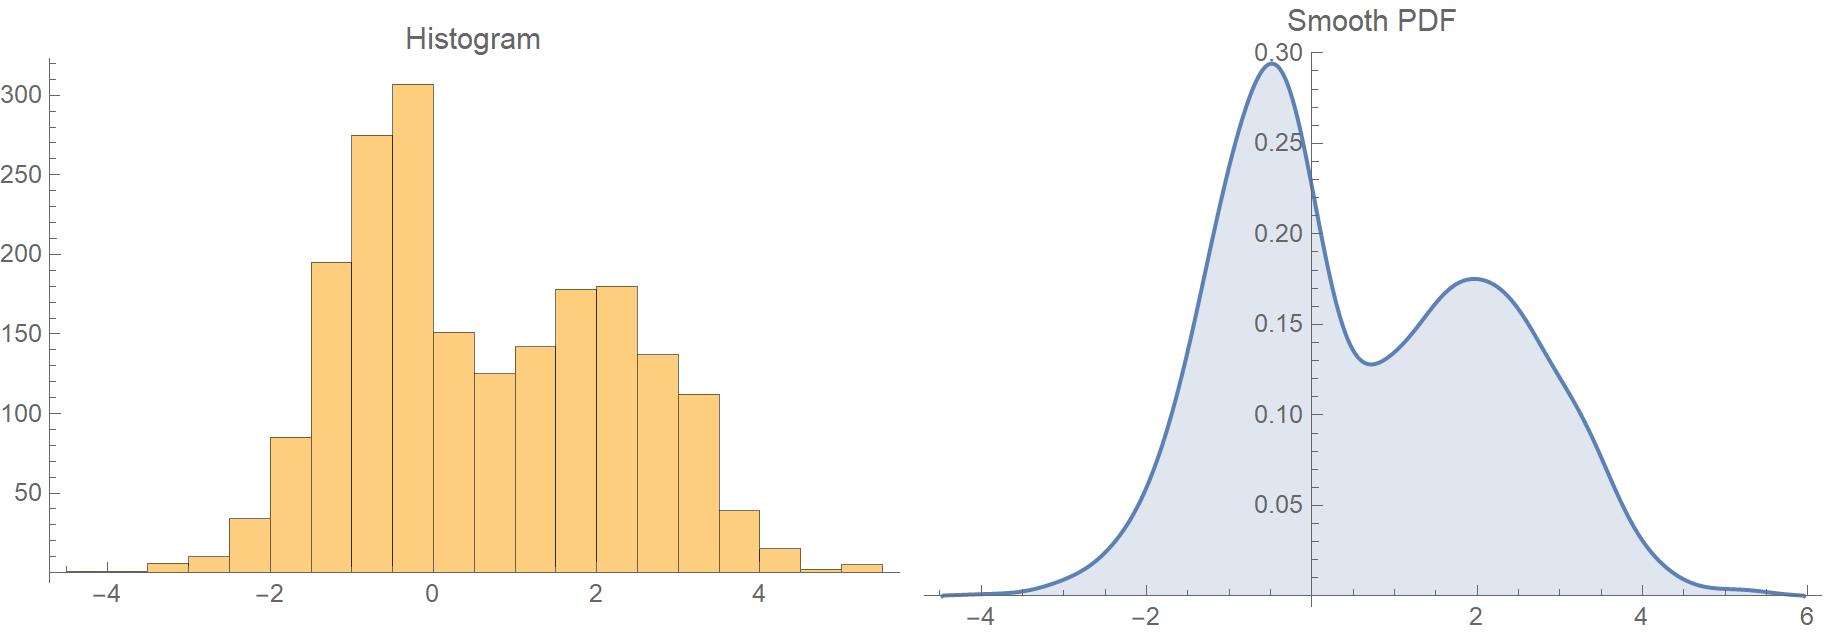!

The shape of the kernel can be essentially whatever you want, but a _Gaussian_ (bell curve) is a good choice since it does a nice job of smoothing things out. 

A nice, clear conceptual explanation of the KDE process can be found [here](https://ekamperi.github.io/math/2020/12/08/kernel-density-estimation.html).

#### **Extract data from all members for a given time period**

We'll choose a couple of interesting time periods to compare: let's say, the past 50 years versus the next 50 years. 

For this, we can use the combination of `.sel()` and `.slice()` applied to the xarray datasets containing temperature for the entire ensemble:

In [17]:
# Get data for an earlier period: 20th century

# Get data for a later period: 21st century


To make it easier to operate on the underlying data (as well as speeding up the next steps in the notebook!), let's also extract the values of the `.pr` variable for each of those epochs into Numpy arrays.

**Note: this step may be quite slow!** On my local laptop, it took roughly 3-5 minutes to run. This will likely be faster on a server or more powerful machine!

In [18]:
# Extract values into Numpy arrays to make it easier to work with in the KDE package


#### Reshape data into a vector

We need to do one more thing before we can calculate our KDE values. Recall that the xarray datasets we are working with have all the ensemble members stored in them: that means that when we extract temperature data for each time period, it has dimension of both `time` and `member`. 

In [32]:
# Print data to demonstrate its shape


If we feed this data directly to `gaussian_kde`, it will calculate separate distributions for each ensemble member! That's not what we want here: since each ensemble member is a distinct _realization_ of the time period we're interested in, by **combining** all of them together we can get a better picture of all the possible variations that COULD have happened during that time period.

...or in other words: the more ensemble members we include, the better an estimate we have of the "true" climate during any given period!

To achieve this, we can use the Numpy `reshape()` function: this can be applied to any Numpy array. Here I'll give it an argument of -1, which means "stick everything together into a single 1D array":

In [20]:
# Reshape Numpy arrays into vectors


#### Apply the KDE, evaluate at specific values

Now we're finally ready to apply the KDE! This is done simply using the `gaussian_kde` command:

In [21]:
# Create KDE objects


The code block above will generate _operators_ that will tell you the value of the probability distribution for any value of temperature! This is kind of conceptually similar to the output produced by `groupby`: the `groupby` function itself makes the groupings, but then you have to actually do something with those groups (like average over them) to get numbers out that you can use.

That means that we have to decide on the values of temperature we're interested in knowing probabilities for! This is equivalent to choosing bins for building a histogram - the only difference is that the probabilities will be connected by a smooth line, rather than having discrete boxes for each temperature value. 

Choosing the bins can be a bit of a trial and error operation sometimes; to get a ballpark idea of the range you need, you can try displaying the mean, minimum, or maximum values from the DataArray before you start! Or you can just pick things that seem reasonable, then see if you're obviously missing the tails of the PDF at the plotting stage;

In [22]:
# Bins: values of temperature at which to evaluate KDEs

# Evaluate KDEs at bin values


Now we've built our two probability arrays, and we can just simply plot them! In the plot below, the PDF for the early period will show up as black (color "k" in Matplotlib), and the PDF for the later period will be a red dashed line (in Matplotlib, this is done using the "r" letter combined with the "--" line style symbol).

In [33]:
# Plot results


<a id='sigtests'></a> 
## **Perform Significance Tests**

From the plot above, it's fairly visually obvious that there is a difference between the temperature distributions in the early versus later periods. But we can be more quantitative about this, using various statistical significance testing procedures!

Two commonly employed tests of significance that we'll demonstrate here are:
- the T-test, sometimes called the Student's T-test: this is a _parametric_ test
- the rank-sum test, sometimes called the Wilcoxon rank-sum test: this is a _non-parametric_ test

### What does it mean for a test to be parametric or non-parametric?

This terminology might seem a little confusing at first, but it boils down to a relatively simple idea:
- **Do you know what your data is supposed to look like?**

If the answer to that question is yes, then you can use a _parametric_ test (since you in theory know the shape - or the _parameters_ - of the data distribution).

If the answer to that question is no, then you should use a _non-parametric_ test that doesn't depend on assuming anything about what the distribution of the data should be!

Usually when we're talking about parametric tests, the assumption we make about the data distribution is that it is _Gaussian_: or, that it follows a traditional "bell curve" shape. 

As you can see from the PDFs above, this is NOT always a good assumption! But here are some examples that will let you apply both types of test anyway.

### Parametric test example: T-test

First, we'll apply the T-test, which is probably the most common type of statistical test you'll encounter. This is a test on the _mean_, which simply asks:
- are the means of two distributions significantly different from each other?

In Python, you can perform a T-test using Scipy's `ttest_ind` function, which is a T test on independent samples of data. More on that function can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)!

In [34]:
# Run T test on early versus late periods

# Look at the p-value


From looking at the p-value above, we see that it's WELL below 0.1 - these changes are highly statistically significant.

BUT, we also can visually see from the PDF plot that the T test isn't actually the most appropriate one to use here! 

### Non-parametric test example: Rank-sum test

Let's apply a non-parametric test since our data has an irregular distribution. In Python, you can use Scipy again to perform this test: it's called `ranksums`:

In [35]:
# Run rank-sum test on early versus late periods

# Print p-value


There you go - in a situation like this where the signal is quite large, you get a highly significant result no matter what test you use!

This concludes this tutorial: now you have some additional statistical tools to put towards your future analyses.